# Problem Statement

In the following notebook we are going to be performing sentiment analysis on a collection of tweets about Apple Inc. After preprocessing, the tweets are labeled as either positive (i.e. I love the new iMac) or negative. (i.e. Apple has bad work poilicies!)

## Data Description

* Tweet Sentiment: Positive Sentiment = 1, Negative Sentiment = 0
* Sentiment Confidence: Range of (0,1) describing the confidence of the sentiment assignment.
* Text: Text composition of the tweet

### Importing Libraries

In [1]:
import nltk
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

### Reading the Dataset

The raw data comes with a lot of information that is not necessary for the analysis. In this section we toss out these sections.

In [13]:
df = pd.read_csv('apple.csv',encoding='latin-1')
df.head()

,unit_id,golden,unit_state,trusted_judgments,last_judgment_at,sentiment,sentiment_confidence,date,id,query,sentiment_gold,text
0,623495513,True,golden,10,NaN,3,0.6264,Mon Dec 01 19:30:03 +0000 2014,540000000000000000,#AAPL OR @Apple,3\nnot_relevant,#AAPL:The 10 best Steve Jobs emails ever...htt...
1,623495514,True,golden,12,NaN,3,0.8129,Mon Dec 01 19:43:51 +0000 2014,540000000000000000,#AAPL OR @Apple,3\n1,RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2,623495515,True,golden,10,NaN,3,1.0000,Mon Dec 01 19:50:28 +0000 2014,540000000000000000,#AAPL OR @Apple,3,My cat only chews @apple cords. Such an #Apple...
3,623495516,True,golden,17,NaN,3,0.5848,Mon Dec 01 20:26:34 +0000 2014,540000000000000000,#AAPL OR @Apple,3\n1,I agree with @jimcramer that the #IndividualIn...
4,623495517,False,finalized,3,2014-12-12T12:14:00,3,0.6474,Mon Dec 01 20:29:33 +0000 2014,540000000000000000,#AAPL OR @Apple,NaN,Nobody expects the Spanish Inquisition #AAPL


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3886 entries, 0 to 3885
Data columns (total 12 columns):
unit_id                 3886 non-null int64
golden                  3886 non-null bool
unit_state              3886 non-null object
trusted_judgments       3886 non-null int64
last_judgment_at        3783 non-null object
sentiment               3886 non-null object
sentiment_confidence    3886 non-null float64
date                    3886 non-null object
id                      3886 non-null int64
query                   3886 non-null object
sentiment_gold          103 non-null object
text                    3886 non-null object
dtypes: bool(1), float64(1), int64(3), object(7)
memory usage: 337.9+ KB


In [15]:
df['sentiment'].value_counts()

3               2162
1               1219
5                423
not_relevant      82
Name: sentiment, dtype: int64

In [16]:
df[df['sentiment'] == '3']['text'].head(10)  ## Neutral Tweets

0     #AAPL:The 10 best Steve Jobs emails ever...htt...
1     RT @JPDesloges: Why AAPL Stock Had a Mini-Flas...
2     My cat only chews @apple cords. Such an #Apple...
3     I agree with @jimcramer that the #IndividualIn...
4          Nobody expects the Spanish Inquisition #AAPL
5     #AAPL:5 Rocket Stocks to Buy for December Gain...
8     Apple Inc. Flash Crash: What You Need to Know ...
9     #AAPL:This Presentation Shows What Makes The W...
11    Apple Watch Tops Search Engine List of Best We...
12    The Best-Designed #iPhone #Apps In the World, ...
Name: text, dtype: object

In [17]:
df[df['sentiment'] == '5']['text'].head(10)   ## Positive tweets

6      Top 3 all @Apple #tablets. Damn right! http://...
7      CNBCTV: #Apple's margins better than expected?...
13     RT @peterpham: Bought my @AugustSmartLock at t...
28     Latest Apple Products Leading in Efficiency ht...
33     RT @saxonidubom: @rwang0 @Apple Thanks...think...
68     Photo: Love IOS 8 @apple @iphone #Love #IOS8 #...
93     Just updated my ram to 16gb. @apple you guys a...
97     IBM: @Apple iOS users account for 21.6% of ALL...
102    @apple please can I have new phone for Christm...
121            Well played @apple http://t.co/mGbsxyiA69
Name: text, dtype: object

In [18]:
df[df['sentiment'] == '1']['text'].head(10)    ## Negative tweets

10    WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
14    @apple Contact sync between Yosemite and iOS8 ...
16    WARNING IF YOU BUY AN IPHONE 5S UNLOCKED FROM ...
23    @Apple, For the love of GAWD, CENTER the '1'on...
24    i get the storage almost full notification lit...
25    I had to do made the #switch from iPhone 6 to ...
26    @ me RT @101Baemations: Can't stand those ppl ...
39    That flash crash really screwed with a lot of ...
41                  Nigga update yall headphones @Apple
43    RT @thehill: Justice Department cites 18th cen...
Name: text, dtype: object

In [19]:
df.loc[26,'text']

"@ me RT @101Baemations: Can't stand those ppl with @Apple stickers everywhere. 9/10 they prob just bought an iPod shuffle"

* Here we can see that some of the tweets are neutral in nature represented by '3'. We are not considering neutral tweets for our model for now but can be used in further scaling of this project.

In [20]:
## Dropping NaN and "neutral" responses to setup a binary analysis

df = df[df['sentiment']!="3"]
df = df[df['sentiment']!='not_relevant']

In [21]:
## Dropping the extra columns

df = df.drop(['unit_id', 'golden', 'unit_state', 'trusted_judgments', 
              'last_judgment_at', 'date','id','query', 'sentiment_gold'], axis =1)
df.reset_index()

,index,sentiment,sentiment_confidence,text
0,6,5,0.8468,Top 3 all @Apple #tablets. Damn right! http://...
1,7,5,0.6736,CNBCTV: #Apple's margins better than expected?...
2,10,1,1.0000,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
3,13,5,1.0000,RT @peterpham: Bought my @AugustSmartLock at t...
4,14,1,1.0000,@apple Contact sync between Yosemite and iOS8 ...
...,...,...,...,...
1637,3878,5,0.6839,RT @shannonmmiller: Love the @Apple is support...
1638,3880,1,0.6619,hey @apple is it normal for my laptop charger ...
1639,3883,5,0.9347,@marcbulandr I could not agree more. Between @...
1640,3884,1,0.9230,My iPhone 5's photos are no longer downloading...


In [22]:
## Function to convert into binary or 1s and 0s for each of the sentiment
    
def binary(x):
    
    if x=='5':
        return 1
    else:
        return 0

In [23]:
df['sentiment'] = df['sentiment'].apply(binary)
df.head()

,sentiment,sentiment_confidence,text
6,1,0.8468,Top 3 all @Apple #tablets. Damn right! http://...
7,1,0.6736,CNBCTV: #Apple's margins better than expected?...
10,0,1.0000,WTF MY BATTERY WAS 31% ONE SECOND AGO AND NOW ...
13,1,1.0000,RT @peterpham: Bought my @AugustSmartLock at t...
14,0,1.0000,@apple Contact sync between Yosemite and iOS8 ...


In [24]:
df.reset_index(drop = True, inplace = True )

In [25]:
print('\n\nSentiment Values: ')
print(df.sentiment.value_counts())



Sentiment Values: 
0    1219
1     423
Name: sentiment, dtype: int64


* We see that there are times as much negative tweets in the data than positive tweets. The model accuracy and performance will increase if we could collect more data for training.

## Preprocessing

Because the data is made up of Tweets, there are many non-text symbols (i.e @, https:, # etc.) throughout our dataset.We will keep some symbols that provide semantics (i.e !,',"). This will only serve to confuse our model and make sentiment predictions less accurate. So we choose to make a simpler and potentially more accurate model by removing those symbols.

In [26]:
## Removes special strings and non text
    
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df

df = standardize_text(df, 'text')
df.to_csv('clean_apple.csv')
df.head()

,sentiment,sentiment_confidence,text
0,1,0.8468,top 3 all tablets damn right!
1,1,0.6736,cnbctv apple's margins better than expected?...
2,0,1.0000,wtf my battery was 31 one second ago and now ...
3,1,1.0000,rt bought my at the store pretty good logo...
4,0,1.0000,contact sync between yosemite and ios8 is ser...


## Data Tokenisation

* Here we turn our twitter strings to lists of individual tokens. (words, punctuations)

In [27]:
from nltk.tokenize import RegexpTokenizer

## NLTK tokenizer

tokenizer = RegexpTokenizer(r'\w+')     ## This regular expression breaks a line into words
df['tokens'] = df['text'].apply(tokenizer.tokenize)
df.head()

,sentiment,sentiment_confidence,text,tokens
0,1,0.8468,top 3 all tablets damn right!,"[top, 3, all, tablets, damn, right]"
1,1,0.6736,cnbctv apple's margins better than expected?...,"[cnbctv, apple, s, margins, better, than, expe..."
2,0,1.0000,wtf my battery was 31 one second ago and now ...,"[wtf, my, battery, was, 31, one, second, ago, ..."
3,1,1.0000,rt bought my at the store pretty good logo...,"[rt, bought, my, at, the, store, pretty, good,..."
4,0,1.0000,contact sync between yosemite and ios8 is ser...,"[contact, sync, between, yosemite, and, ios8, ..."


### Sentence Length and Vocabulary Size

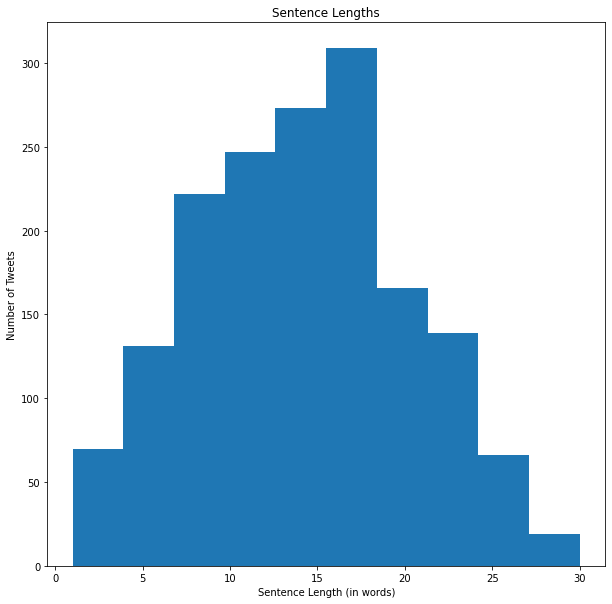

In [30]:
sentence_lengths = [len(tokens) for tokens in df['tokens']]
vocab = sorted(list(set([word for tokens in df['tokens'] for word in tokens]))) ## Iteration

plt.figure(figsize = (10,10))
plt.xlabel('Sentence Length (in words)')
plt.ylabel('Number of Tweets')
plt.title('Sentence Lengths')
plt.hist(sentence_lengths)
plt.show()

In [31]:
print('Words in vocab: ', len(vocab))

Words in vocab:  3701


* We have an average sentence length around 14-15 words, and a vocabulary size of 3,701 unique words.

## Bag Of Words

* We will use TF-IDF to convert our token lists to numerical data.

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

X = df['text']
y = df['sentiment']
sent_confidence = df['sentiment_confidence']

## We can see save the processed data if needed into a new file.

In [33]:
## Splitting data for cross train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 
print(X_train[:5])

1236    for a limited time, the ibookstore is offering...
1521    the hell does this mean  one day skype won't l...
1315    why does  yosemite constantly restart due to a...
31        what a joke! justice dept should prosecute k...
938     rt  hey  how about you guys make a charger tha...
Name: text, dtype: object


In [34]:
## Vectorization of the training data with TFIDF and scikit learn

vect = TfidfVectorizer()
X_train_tfidf = vect.fit_transform(X_train)
X_test_tfidf = vect.transform(X_test)

In [35]:
X_train_tfidf[0]

<1x2976 sparse matrix of type '<class 'numpy.float64'>'
	with 13 stored elements in Compressed Sparse Row format>

In [36]:
## Vectorisation of the complete data for cross validation and training

vect = TfidfVectorizer()
X_tfidf = vect.fit_transform(X)

## Model Building

So now we will predict the whether the tweet sentiment is positive or not using Classification Algorithms. Following are the algorithms I will use to make the model:

1. Logistic Regression

2. Support Vector Machines (Linear)

3. Random Forest

4. K-Nearest Neighbours

5. Decision Tree

In [37]:
## Importing all the required ML packages

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics 
from sklearn.metrics import confusion_matrix,classification_report 

### Logistic Regression

In [38]:
model = LogisticRegression()
model.fit(X_train_tfidf,y_train)
prediction1 = model.predict(X_test_tfidf)
print('The accuracy of the Logistic Regression is',metrics.accuracy_score(y_test,prediction1))

The accuracy of the Logistic Regression is 0.8275862068965517


### Linear Support Vector Machine

In [39]:
model = svm.SVC(kernel='linear',C=1,gamma=0.1)
model.fit(X_train_tfidf,y_train)
prediction2 = model.predict(X_test_tfidf)
print('Accuracy for linear SVM is',metrics.accuracy_score(y_test,prediction2))

Accuracy for linear SVM is 0.8620689655172413


### Random Forests

In [40]:
model = RandomForestClassifier(n_estimators=100, random_state= 42)
model.fit(X_train_tfidf,y_train)
prediction3 = model.predict(X_test_tfidf)
print('The accuracy of the Random Forests is',metrics.accuracy_score(y_test,prediction3))

The accuracy of the Random Forests is 0.8296146044624746


### K-Nearest Neighbours(KNN)

In [41]:
model = KNeighborsClassifier() 
model.fit(X_train_tfidf,y_train)
prediction4 = model.predict(X_test_tfidf)
print('The accuracy of the KNN is',metrics.accuracy_score(y_test,prediction4))

The accuracy of the KNN is 0.8275862068965517


Now the accuracy for the KNN model changes as we change the values for **n_neighbours** attribute. Lets check the accuracies over various values of n_neighbours.

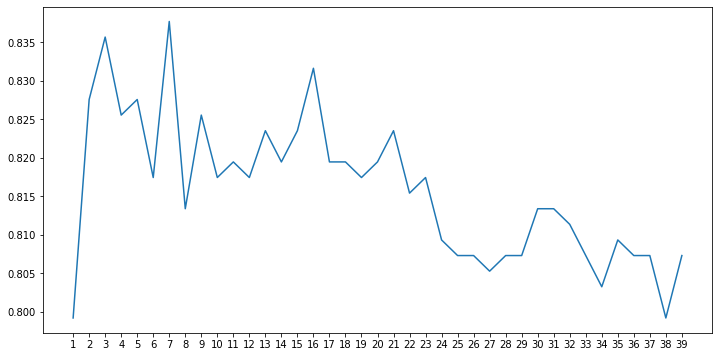

Accuracies for different values of n are: [0.79918864 0.82758621 0.8356998  0.82555781 0.82758621 0.81744422
 0.83772819 0.81338742 0.82555781 0.81744422 0.81947262 0.81744422
 0.82352941 0.81947262 0.82352941 0.831643   0.81947262 0.81947262
 0.81744422 0.81947262 0.82352941 0.81541582 0.81744422 0.80933063
 0.80730223 0.80730223 0.80527383 0.80730223 0.80730223 0.81338742
 0.81338742 0.81135903 0.80730223 0.80324544 0.80933063 0.80730223
 0.80730223 0.79918864 0.80730223] with the max value as  0.8377281947261663


In [46]:
a_index = list(range(1,40))
a=pd.Series()
x= list(range(1,40))
for i in list(range(1,40)):
    model = KNeighborsClassifier(n_neighbors=i) 
    model.fit(X_train_tfidf,y_train)
    prediction = model.predict(X_test_tfidf)
    a=a.append(pd.Series(metrics.accuracy_score(y_test,prediction)))    

plt.plot(a_index, a)
plt.xticks(x)
fig = plt.gcf()
fig.set_size_inches(12,6)
plt.show()
print('Accuracies for different values of n are:',a.values,'with the max value as ',a.values.max())

### Decision Tree

In [48]:
model = DecisionTreeClassifier()
model.fit(X_train_tfidf,y_train)
prediction5 = model.predict(X_test_tfidf)
print('The accuracy of the Decision Tree is',metrics.accuracy_score(y_test,prediction5))


The accuracy of the Decision Tree is 0.7545638945233266


The accuracy of a model is not the only factor that determines the robustness of the classifier. As the training and testing data changes, the accuracy will also change. It may increase or decrease. This is known as **model variance**.

To overcome this and get a generalized model,we use **Cross Validation**.

Many a times, the data is imbalanced, i.e there may be a high number of one specific class instances but less number of other class instances. Thus we should train and test our algorithm on each and every instance of the dataset. Then we can take an average of all the noted accuracies over the dataset.

An algorithm may underfit over a dataset for some training data and sometimes also overfit the data for other training set. Thus with cross-validation, we can achieve a generalised model.

* As we can see the best performing algorithms are SVM (Linear), Random Forest Classifer, Logistic Regression and KNN.
* Cross Validation is a type of resampling method and it should be done on the complete data to know how our model will work when subjected to different data.

## Cross Validation

In [49]:
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import cross_val_predict

In [50]:
kfold = KFold(n_splits=10, random_state= 42) 
mean=[]
accuracy=[]
std=[]

classifiers=['Linear Svm','LogisticRegression','KNN','Random Forest']

models=[svm.SVC(kernel='linear'),LogisticRegression(),KNeighborsClassifier(n_neighbors=7),RandomForestClassifier(n_estimators=100, random_state=42)]

for i in models:
    model = i
    cv_result = cross_val_score(model, X_tfidf, y, cv = kfold, verbose = 1, scoring = "accuracy")
    cv_result = cv_result
    mean.append(cv_result.mean())
    std.append(cv_result.std())
    accuracy.append(cv_result)
    
new_models_dataframe2 = pd.DataFrame({'CV Mean':mean,'Std':std},index=classifiers)       
new_models_dataframe2

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   12.0s finished


,CV Mean,Std
Linear Svm,0.834335,0.051181
LogisticRegression,0.794124,0.052539
KNN,0.811194,0.039750
Random Forest,0.802033,0.051082


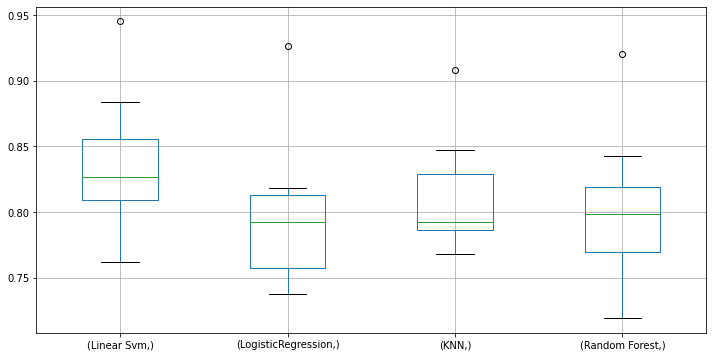

In [51]:
plt.subplots(figsize=(12,6))
acc_mat = pd.DataFrame(accuracy,index=[classifiers])
acc_mat.T.boxplot()

In [52]:
acc_mat = pd.DataFrame(accuracy,index=[classifiers])
acc_mat

,0,1,2,3,4,5,6,7,8,9
Linear Svm,0.860606,0.830303,0.884146,0.841463,0.823171,0.945122,0.804878,0.823171,0.762195,0.768293
LogisticRegression,0.818182,0.818182,0.798780,0.756098,0.762195,0.926829,0.792683,0.792683,0.737805,0.737805
KNN,0.836364,0.806061,0.786585,0.786585,0.786585,0.908537,0.847561,0.792683,0.792683,0.768293
Random Forest,0.842424,0.824242,0.804878,0.768293,0.768293,0.920732,0.798780,0.798780,0.774390,0.719512


* Here, we can see that the Linear SVM, KNN, Logistic Regression and Random Forest are performing well enough after cross validation.
* Linear SVM is having a higher mean accuracy score.
* From the cross validation scores we can see that there is enough variance in the performance of all models with different data and therefore we can assume that performance of model is subjective to data.

## Model Evaluation

We can get a summarized result with the help of a classification report and confusion matrix, which shows where did the model go wrong, or which class did the model predict wrong.

They give the number of correct and incorrect classifications made by the classifier.

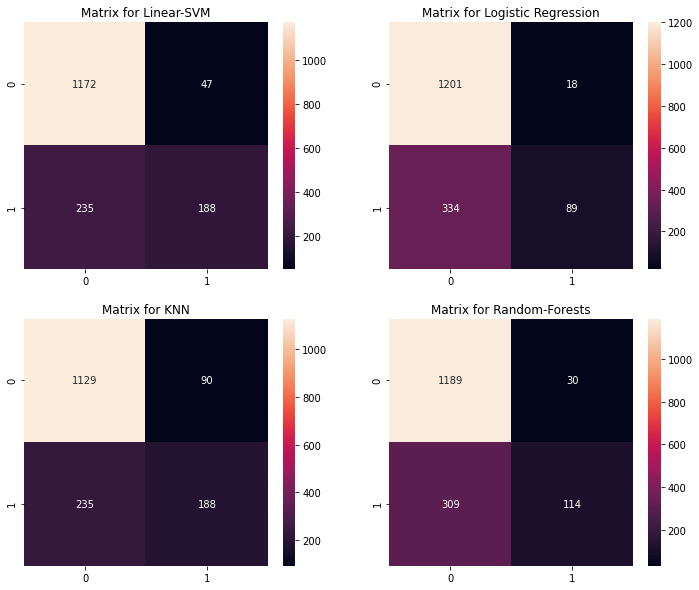

In [53]:
f,ax=plt.subplots(2,2,figsize=(12,10))

y_pred1 = cross_val_predict(svm.SVC(kernel='linear'), X_tfidf, y, cv=10)
sns.heatmap(confusion_matrix(y,y_pred1),ax=ax[0,0],annot=True,fmt='2.0f')
ax[0,0].set_title('Matrix for Linear-SVM')

y_pred2 = cross_val_predict(LogisticRegression(), X_tfidf, y, cv=10)
sns.heatmap(confusion_matrix(y,y_pred2),ax=ax[0,1],annot=True,fmt='2.0f')
ax[0,1].set_title('Matrix for Logistic Regression')

y_pred3 = cross_val_predict(KNeighborsClassifier(n_neighbors=7), X_tfidf, y, cv=10)
sns.heatmap(confusion_matrix(y,y_pred3),ax=ax[1,0],annot=True,fmt='2.0f')
ax[1,0].set_title('Matrix for KNN')

y_pred4 = cross_val_predict(RandomForestClassifier(n_estimators=100, random_state = 42), X_tfidf, y, cv=10)
sns.heatmap(confusion_matrix(y,y_pred4),ax=ax[1,1],annot=True,fmt='2.0f')
ax[1,1].set_title('Matrix for Random-Forests')

plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()


From the confusion matrix we can infer the following:

* The model as it was trained with more negative samples has a bias towards negative tweets. There is higher chance of prediction to be negative.
* It can be seen there are less number of samples predicted as positive.
* In all the models, there is high **False Negative** prediction which means that the model is not very adept at predicting positive tweets.
* We need a model with less False Negative and False Positive predictions and therefore we can choose SVM model to be better than others
* There is a a need to train the model with more data to improve the model accuracy in the future.

In [54]:
y_pred1 = cross_val_predict(svm.SVC(kernel='linear'), X_tfidf, y, cv=10)
print("\n Classification Report for Linear SVM: \n ",classification_report(y,y_pred1))

y_pred2 = cross_val_predict(LogisticRegression(), X_tfidf, y, cv=10)
print("\n Classification Report for Logistic Regression: \n ",classification_report(y,y_pred2))

y_pred3 = cross_val_predict(KNeighborsClassifier(n_neighbors=7), X_tfidf, y, cv=10)
print("\n Classification Report for KNN: \n ",classification_report(y,y_pred3))

y_pred4 = cross_val_predict(RandomForestClassifier(n_estimators=100, random_state = 42), X_tfidf, y, cv=10)
print("\n Classification Report for Random Forest Classifier: \n ",classification_report(y,y_pred4))


 Classification Report for Linear SVM: 
                precision    recall  f1-score   support

           0       0.83      0.96      0.89      1219
           1       0.80      0.44      0.57       423

    accuracy                           0.83      1642
   macro avg       0.82      0.70      0.73      1642
weighted avg       0.82      0.83      0.81      1642


 Classification Report for Logistic Regression: 
                precision    recall  f1-score   support

           0       0.78      0.99      0.87      1219
           1       0.83      0.21      0.34       423

    accuracy                           0.79      1642
   macro avg       0.81      0.60      0.60      1642
weighted avg       0.80      0.79      0.73      1642


 Classification Report for KNN: 
                precision    recall  f1-score   support

           0       0.83      0.93      0.87      1219
           1       0.68      0.44      0.54       423

    accuracy                           0.80      16

## Hyper Parameter Tuning

Hyper Parameter Tuning can be done to change the learning rate of the algorithm and get a better model. The follwoing models can be tuned: 

1. Linear SVM
2. KNN
3. Random Forest Classifier

### SVM

In [55]:
from sklearn.model_selection import GridSearchCV

C=[0.01,0.1,0.5,1,10]
gamma=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
kernel=['rbf','linear','poly']
degree = [2,3,4]
param={'kernel':kernel, 'C':C, 'gamma':gamma, 'degree':degree}

#gd1 = GridSearchCV(estimator=svm.SVC(), param_grid=param, cv = 10, n_jobs =-1, verbose=True)
#gd1.fit(X_tfidf,y)

print(gd1.best_score_)
print(gd1.best_estimator_)



Fitting 10 folds for each of 450 candidates, totalling 4500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 4500 out of 4500 | elapsed:  8.7min finished


0.8282582216808769
SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=2, gamma=0.1, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


**Support Vector Machines:**

* Best Score: 82.82%
* Best Estimator: SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
        decision_function_shape='ovr', degree=2, gamma=0.1, kernel='linear',
        max_iter=-1, probability=False, random_state=None, shrinking=True,
        tol=0.001, verbose=False)

In [56]:
estimator = gd1.best_estimator_
pred1 = cross_val_predict(estimator,X_tfidf,y,cv=10)

In [57]:
pred1 = pd.DataFrame(pred1,columns= ['SVM_prediction'])
pred1

,SVM_prediction
0,0
1,0
2,0
3,0
4,0
...,...
1637,1
1638,0
1639,1
1640,0


In [60]:
pred1.to_csv('SVM_prediction.csv')

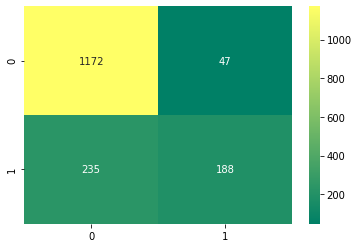


Classification Report: 

               precision    recall  f1-score   support

           0       0.83      0.96      0.89      1219
           1       0.80      0.44      0.57       423

    accuracy                           0.83      1642
   macro avg       0.82      0.70      0.73      1642
weighted avg       0.82      0.83      0.81      1642



In [61]:
sns.heatmap(confusion_matrix(y,pred1),cmap='summer',annot=True,fmt='2.0f')
plt.show()
print("\nClassification Report: \n\n",classification_report(y,pred1))


### Random Forest

In [62]:
param = {'max_depth':[3, None], 'min_samples_split':[2, 3, 10], 
              'min_samples_leaf':[1, 3, 10], 'bootstrap':[True, False], 
              'criterion':["gini", "entropy"], 
              'n_estimators':[100,500,1000,1500]}

#gd2 = GridSearchCV(estimator = RandomForestClassifier(random_state=42), param_grid = param, cv=10, verbose=1, n_jobs = -1, scoring = "accuracy")
#gd2.fit(X_tfidf,y)

print(gd2.best_score_)
print(gd2.best_estimator_)



Fitting 10 folds for each of 288 candidates, totalling 2880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 24.4min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 31.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 51.4min
[Parallel(n_jobs=-1)]: Done 2880 out of 2880 | elapsed: 69.8min finished


0.805115712545676
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)


**Random Forest Classifier:**

* Best Score: 80.51%
* Best Estimator: RandomForestClassifier(bootstrap=False, class_weight=None, criterion='entropy',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [63]:
estimator = gd2.best_estimator_
pred2 = cross_val_predict(estimator,X_tfidf,y,cv=10)


In [64]:
pred2 = pd.DataFrame(pred2,columns= ['RF_prediction'])
pred2

,RF_prediction
0,0
1,0
2,0
3,0
4,0
...,...
1637,1
1638,0
1639,0
1640,0


In [65]:
pred2.to_csv('RF_prediction.csv')

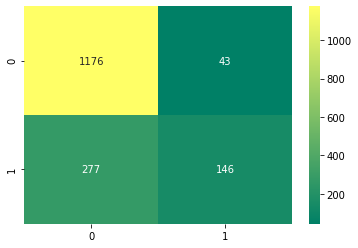


Classification Report: 

               precision    recall  f1-score   support

           0       0.81      0.96      0.88      1219
           1       0.77      0.35      0.48       423

    accuracy                           0.81      1642
   macro avg       0.79      0.65      0.68      1642
weighted avg       0.80      0.81      0.78      1642



In [67]:
sns.heatmap(confusion_matrix(y,pred2),cmap='summer',annot=True,fmt='2.0f')
plt.show()
print("\nClassification Report: \n\n",classification_report(y,pred2))

### KNN

In [69]:
n_neighbors = range(1, 21, 1)
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan', 'minkowski']

param = dict(n_neighbors = n_neighbors, weights = weights, metric = metric)
#gd3 = GridSearchCV(estimator= KNeighborsClassifier() , param_grid = param, cv = 10, scoring='accuracy', verbose = True, n_jobs=-1)
#gd3.fit(X_tfidf, y)

print(gd3.best_score_)
print(gd3.best_estimator_)


Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 404 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 712 tasks      | elapsed:   47.5s


0.8112058465286236
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='distance')


[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:  1.0min finished


**K Nearest Neighbours:**

* Best Score: 81.12%
* Best Estimator: KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='euclidean',
                     metric_params=None, n_jobs=None, n_neighbors=8, p=2,
                     weights='distance')

In [74]:
estimator = gd3.best_estimator_
pred3 = cross_val_predict(estimator,X_tfidf,y,cv=10)

In [75]:
pred3 = pd.DataFrame(pred3,columns= ['KNN_prediction'])
pred3

,KNN_prediction
0,0
1,0
2,0
3,0
4,0
...,...
1637,1
1638,0
1639,0
1640,0


In [76]:
pred3.to_csv('KNN_prediction.csv')

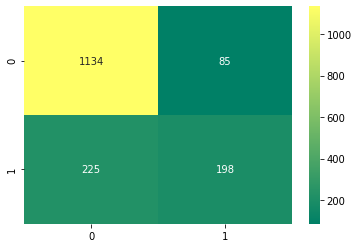


Classification Report: 

               precision    recall  f1-score   support

           0       0.83      0.93      0.88      1219
           1       0.70      0.47      0.56       423

    accuracy                           0.81      1642
   macro avg       0.77      0.70      0.72      1642
weighted avg       0.80      0.81      0.80      1642



In [77]:
sns.heatmap(confusion_matrix(y,pred3),cmap='summer',annot=True,fmt='2.0f')
plt.show()
print("\nClassification Report: \n\n",classification_report(y,pred3))

From the hyper parameter tuning, we can see that all the models perform well but Linear SVM is having a slight advantage when it comes to overall accuracy.

## Boosting

It is an ensemble technique used for the step by step enhancement of a weak model. 

Boosting works as follows:

A model is first trained on the complete dataset. Now the model will get some instances right while some wrong. Now in the next iteration, the learner will focus more on the wrongly predicted instances or give more weight to it. Thus it will try to predict the wrong instance correctly. Now this iterative process continous, and new classifers are added to the model until the limit is reached on the accuracy.

### AdaBoost

In [78]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=200,random_state=42,learning_rate=0.1)
result = cross_val_score(ada,X_tfidf,y,cv=10,scoring='accuracy')
print('The cross validated score for AdaBoost is:',result.mean())

The cross validated score for AdaBoost is: 0.8001866109849051


### XGBoost

In [79]:
import xgboost as xg

xgboost = xg.XGBClassifier(n_estimators=900,learning_rate=0.1)
result=cross_val_score(xgboost,X_tfidf,y,cv=10,scoring='accuracy')
print('The cross validated score for XGBoost is:',result.mean())

The cross validated score for XGBoost is: 0.7873926833802638


We see that we get a greater score for AdaBoost and let's do further tuning.

In [80]:
n_estimators=list(range(100,1100,100))
learn_rate=[0.05,0.1,0.2,0.5,1]

param = {'n_estimators':n_estimators,'learning_rate':learn_rate}

#gd4 = GridSearchCV(estimator=AdaBoostClassifier(),param_grid=param ,cv = 10, verbose=True, n_jobs=-1)
#gd4.fit(X_tfidf,y)

print(gd4.best_score_)
print(gd4.best_estimator_)


Fitting 10 folds for each of 50 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   47.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed: 16.3min finished


0.8063337393422655
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.05,
                   n_estimators=1000, random_state=None)


**AdaBoost:**

* Best Score: 80.63%
* Best Estimator: AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.05,
                   n_estimators=1000, random_state=None)

In [81]:
estimator = gd4.best_estimator_
pred4 = cross_val_predict(estimator,X_tfidf,y,cv=10)

In [82]:
pred4 = pd.DataFrame(pred4,columns= ['Boost_prediction'])
pred4

,Boost_prediction
0,0
1,0
2,0
3,0
4,0
...,...
1637,1
1638,0
1639,0
1640,0


In [83]:
pred4.to_csv('Boost_prediction.csv')

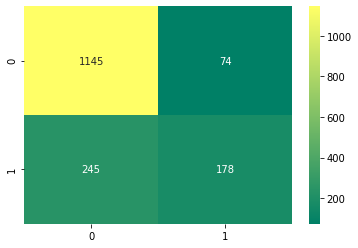


Classification Report: 

               precision    recall  f1-score   support

           0       0.82      0.94      0.88      1219
           1       0.71      0.42      0.53       423

    accuracy                           0.81      1642
   macro avg       0.77      0.68      0.70      1642
weighted avg       0.79      0.81      0.79      1642



In [85]:
sns.heatmap(confusion_matrix(y,pred4),cmap='summer',annot=True,fmt='2.0f')
plt.show()
print("\nClassification Report: \n\n",classification_report(y,pred4))

We can observe that the SVM model when hypertuned still work better than the boosting models. So we will stick to it.

## Confusion Matrix and Classification Report for the Best Model

### Support Vector Machine

In [96]:
model_best = svm.SVC(C=1, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=2, gamma=0.1, kernel='linear',
                  max_iter=-1, probability=False, random_state=42, shrinking=True, tol=0.001, verbose=False)

model_best.fit(X_tfidf,y)
prediction = cross_val_predict(model_best,X_tfidf,y, cv=10, verbose = 1,n_jobs =-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    6.7s finished


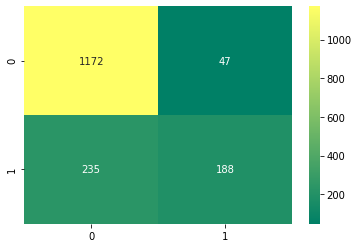


 Classification Report for SVM: 
                precision    recall  f1-score   support

           0       0.83      0.96      0.89      1219
           1       0.80      0.44      0.57       423

    accuracy                           0.83      1642
   macro avg       0.82      0.70      0.73      1642
weighted avg       0.82      0.83      0.81      1642



In [93]:
sns.heatmap(confusion_matrix(y,prediction),cmap='summer',annot=True,fmt='2.0f')
plt.show()
print("\n Classification Report for SVM: \n ",classification_report(y,prediction))

## Conclusion

* We built a linear model that predicts the sentiment of tweets about Apple at around 83% accuracy. 
* The Confusion Matrix showed a tendency towards false negatives. Lastly we showed that the model succesfully inferred the importance of some english words to twitter sentiment.
* More and better data is needed to improve the model accuracy and also reduce it's bias to negative tweets.